A keras verison of the MMD-Variational-Autoencoder is implemented here.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math, os
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Reshape, Flatten
from keras.models import Model
from keras.utils import plot_model
import pdb
from keras import backend as K
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
'Set parameters'
z_dim = 2
epoch = 100
batch_size = 200

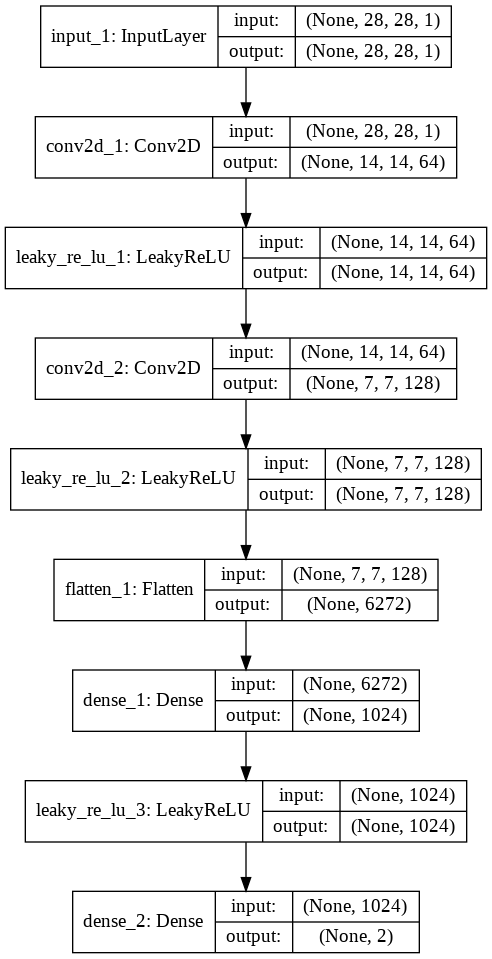

In [3]:
'Build the encoder'
encoder_input = Input(shape=(28, 28, 1))
en_conv1 = Conv2D(filters = 64, kernel_size=4, strides=2, padding='same')(encoder_input)
en_conv1 = LeakyReLU(0.1)(en_conv1)

en_conv2 = Conv2D(filters = 128, kernel_size=4, strides=2, padding='same')(en_conv1)
en_conv2 = LeakyReLU(0.1)(en_conv2)

en_conv2 = Flatten()(en_conv2)
en_fc1 = Dense(1024)(en_conv2)
en_fc1 = LeakyReLU(0.1)(en_fc1)

encoder_output = Dense(z_dim)(en_fc1)

encoder = Model(encoder_input, encoder_output, name='encoder')
# plot_model(encoder, show_shapes=True)

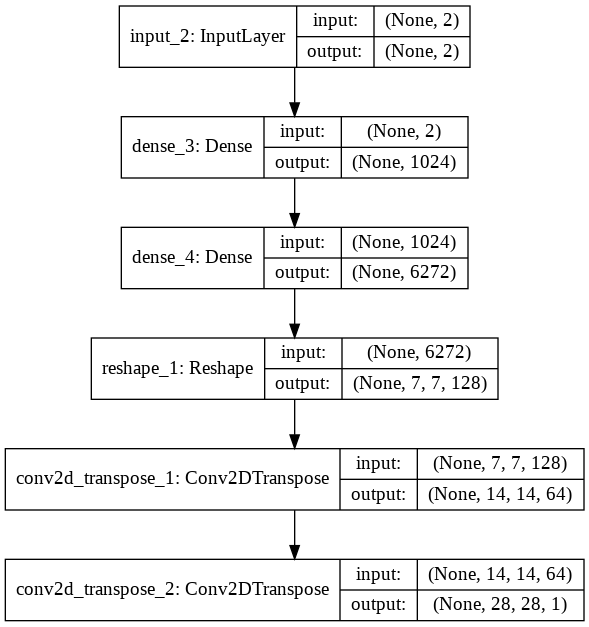

In [4]:
'Build the decoder'
decoder_input = Input(shape=(z_dim,))
de_fc1 = Dense(1024, activation='relu')(decoder_input)
de_fc2 = Dense(7*7*128, activation='relu')(de_fc1)
de_fc2 = Reshape((7, 7, 128))(de_fc2)
de_conv1 = Conv2DTranspose(filters=64, kernel_size=4, strides=2, activation='relu', padding='same')(de_fc2)
decoder_output = Conv2DTranspose(filters=1, kernel_size=4, strides=2, activation='sigmoid', padding='same')(de_conv1)

decoder = Model(decoder_input, decoder_output, name='decoder')
# plot_model(decoder, show_shapes=True)

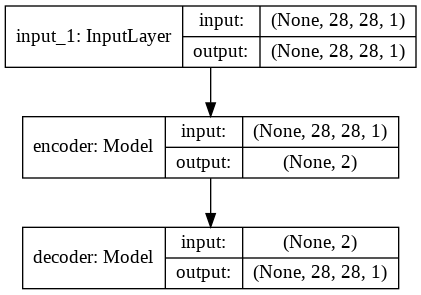

In [5]:
'Build the computation graph for training'
train_z = encoder(encoder_input)
train_xr = decoder(train_z)
autoencoder = Model(encoder_input, train_xr)

# plot_model(autoencoder, show_shapes=True)

In [6]:
# Build the computation graph for generating samples
'our decoder can do this job, no more action needed'

'our decoder can do this job, no more action needed'

In [0]:
'MMD functions'
def compute_kernel(x, y):
    x_size = K.shape(x)[0]
    y_size = K.shape(y)[0]
    dim = K.shape(x)[1]
    tiled_x = K.tile(K.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
    tiled_y = K.tile(K.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
    return K.exp(-K.mean(K.square(tiled_x - tiled_y), axis=2) / K.cast(dim, 'float32'))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return K.mean(x_kernel) + K.mean(y_kernel) - 2 * K.mean(xy_kernel)

In [0]:
def custom_loss(train_z, train_xr, train_x):
    """
    Critical loss builder
		:param train_z: latent code
		:param train_xr: reconstructed data
		:param train_x: training data, the input data
		:return: new loss
		"""
    'So, we first get the mmd loss'
    'First, sample from random noise'
    batch_size = K.shape(train_z)[0]
    latent_dim = K.int_shape(train_z)[1]
    true_samples = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    'calculate mmd loss'
    loss_mmd = compute_mmd(true_samples, train_z)

    'Then, also get the reconstructed loss'
    loss_nll = K.mean(K.square(train_xr - train_x))

    'Add them together, then you can get the final loss'
    loss = loss_nll + loss_mmd
    return loss

In [9]:
'Time to prepare the data'
# Loads the training and test data sets (ignoring class labels)
(x_train, _), (x_test, y_test) = mnist.load_data()

# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

11493376/11490434 [==============================] - 2s 0us/step


In [10]:
'compile the model, prepare for training'
loss = custom_loss(train_z, train_xr, encoder_input)
autoencoder.add_loss(loss)
autoencoder.compile(optimizer='adam')

In [11]:
'Train the model'
autoencoder.fit(x_train,
				epochs=epoch,
				batch_size=batch_size,
				shuffle=True,
				validation_data=(x_test, None)
				)


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 15s 250us/step - loss: 0.1016 - val_loss: 0.0948
Epoch 2/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0560 - val_loss: 0.0865
Epoch 3/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0532 - val_loss: 0.0811
Epoch 4/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0519 - val_loss: 0.0748
Epoch 5/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.0506 - val_loss: 0.0734
Epoch 6/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.0494 - val_loss: 0.0699
Epoch 7/100
60000/60000 [==============================] - 7s 121us/step - loss: 0.0487 - val_loss: 0.0702
Epoch 8/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.0478 - val_loss: 0.0691
Epoch 9/100
60000/60000 [==============================] - 7s 121us/step - loss: 0.0470 - va

In [0]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

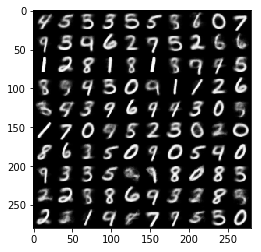

In [13]:
'Time to evaluate'
random_noise = np.random.normal(size=(100, z_dim))
samples = decoder.predict(random_noise)
plt.imshow(convert_to_display(samples), cmap='Greys_r')
plt.show()

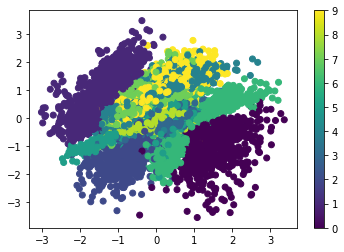

In [14]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
if z_dim == 2:
    z = encoder.predict(x_test)
    label = y_test
    plt.scatter(z[:, 0], z[:, 1], c=label)
    plt.colorbar()
    plt.show()